# Setup

In [1]:
import warnings
import numpy as np
from keras.layers import Input, Dense, Lambda, Concatenate, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
# import tensorflow.keras.backend as K
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers.legacy import Adam
from keras.utils import plot_model

import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# import tensorflow._api.v2.compat.v1 as tf
# tf.disable_v2_behavior()
warnings.filterwarnings('ignore')

2023-07-24 14:27:37.450589: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 14:27:37.472531: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 14:27:37.472946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 14:27:37.889071: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


 # CVAE simple

## Data processing

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

## Modelamiento
### Hiperparámetros

In [3]:
batch_size = 250 # batch size
latent_dim = 2 # latent space size
optim = Adam(lr=0.001)
n_x = X_train.shape[1]
n_y = y_train.shape[1]
n_epoch = 50

### Encoder

In [4]:
encoder_inp1 = Input(shape=(n_x,), name="input_image")
encoder_inp2 = Input(shape=(n_y,), name="input_label")
enc_concat = Concatenate(name="encoder_concatenate")([encoder_inp1, encoder_inp2])
encoder_hidden = Dense(512, name="hidden_layer")(enc_concat)
mu = Dense(latent_dim, activation='linear', name="mu")(encoder_hidden)
l_sigma = Dense(latent_dim, activation='linear', name="l_sigma")(encoder_hidden)
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(latent_dim, ), mean=0., stddev=1.) # shape antes => (batch_size, latent_dim)
    return mu + K.exp(l_sigma / 2) * eps
z = Lambda(sample_z, output_shape = (latent_dim, ), name="latent_vector")([mu, l_sigma]) # output encoder

encoder = Model([encoder_inp1, encoder_inp2], z, name="encoder")

In [6]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 784)]                0         []                            
                                                                                                  
 input_label (InputLayer)    [(None, 10)]                 0         []                            
                                                                                                  
 encoder_concatenate (Conca  (None, 794)                  0         ['input_image[0][0]',         
 tenate)                                                             'input_label[0][0]']         
                                                                                                  
 hidden_layer (Dense)        (None, 512)                  407040    ['encoder_concatenate[0]

### Decoder

In [7]:
decoder_inp1 = Input(shape=(latent_dim), name="input_latent_vector")
decoder_inp2 = Input(shape=(n_y), name = "input_label")
dec_concat = Concatenate(name="decoder_concat")([decoder_inp1, decoder_inp2]) 
decoder_hidden = Dense(512, activation="relu", name="hidden_layer")(dec_concat)
output = Dense(n_x, activation="sigmoid", name="output_img")(decoder_hidden) # output img
decoder = Model([decoder_inp1, decoder_inp2], output, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_latent_vector (Input  [(None, 2)]                  0         []                            
 Layer)                                                                                           
                                                                                                  
 input_label (InputLayer)    [(None, 10)]                 0         []                            
                                                                                                  
 decoder_concat (Concatenat  (None, 12)                   0         ['input_latent_vector[0][0]', 
 e)                                                                  'input_label[0][0]']         
                                                                                            

### Conditional variational autoencoder

In [8]:
latent_vector = encoder(inputs=[encoder_inp1, encoder_inp2]) # z
output_img = decoder(inputs=[latent_vector, encoder_inp2])
CVAE = Model(inputs=[encoder_inp1, encoder_inp2], outputs=output_img, name="CVAE")
CVAE.summary()

Model: "CVAE"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 784)]                0         []                            
                                                                                                  
 input_label (InputLayer)    [(None, 10)]                 0         []                            
                                                                                                  
 encoder (Functional)        (None, 2)                    409092    ['input_image[0][0]',         
                                                                     'input_label[0][0]']         
                                                                                                  
 decoder (Functional)        (None, 784)                  408848    ['encoder[0][0]',          

## Entrenamiento

In [9]:
def vae_loss(y_true, y_pred):
    recon = recon_loss(y_true, y_pred)
    kl = KL_loss(y_true, y_pred)
    return recon + kl

def KL_loss(y_true, y_pred): # it doesnt use y_true and y_pred but the parameters are necessary for compiling
     # importante se usan las capas de mu y sigma del encoder
	return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [10]:
CVAE.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss])

In [11]:
cvae_hist = CVAE.fit([X_train, y_train], X_train, verbose = 1, batch_size=batch_size, epochs=n_epoch,
                      validation_data = ([X_test, y_test], X_test),
                      callbacks = [EarlyStopping(patience = 5)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 2750/60000 [>.............................] - ETA: 2s - loss: 461.1898 - KL_loss: 32.0418 - recon_loss: 429.1480

2023-07-24 14:31:19.807275: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-07-24 14:31:19.807296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: mordor
2023-07-24 14:31:19.807299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: mordor
2023-07-24 14:31:19.807359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.116.4
2023-07-24 14:31:19.807370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.116.4
2023-07-24 14:31:19.807372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.116.4
2023-07-24 14:31:19.816872: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-07-24 14:31:19.

60000/60000 [==============================] - 1s 22us/sample - loss: 202.5425 - KL_loss: 10.9922 - recon_loss: 191.5504 - val_loss: 161.0123 - val_KL_loss: 5.1330 - val_recon_loss: 155.8793
Epoch 2/50
 2750/60000 [>.............................] - ETA: 1s - loss: 159.2400 - KL_loss: 4.7063 - recon_loss: 154.5337

2023-07-24 14:31:21.108865: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/mul' id:278 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/decoder_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


60000/60000 [==============================] - 1s 20us/sample - loss: 155.5990 - KL_loss: 4.7612 - recon_loss: 150.8379 - val_loss: 150.4927 - val_KL_loss: 4.1087 - val_recon_loss: 146.3840
Epoch 3/50
60000/60000 [==============================] - 1s 20us/sample - loss: 149.9958 - KL_loss: 4.5659 - recon_loss: 145.4299 - val_loss: 146.7016 - val_KL_loss: 4.1735 - val_recon_loss: 142.5281
Epoch 4/50
60000/60000 [==============================] - 1s 20us/sample - loss: 147.6305 - KL_loss: 4.4763 - recon_loss: 143.1543 - val_loss: 145.0735 - val_KL_loss: 4.9209 - val_recon_loss: 140.1525
Epoch 5/50
60000/60000 [==============================] - 1s 20us/sample - loss: 145.4643 - KL_loss: 4.3408 - recon_loss: 141.1234 - val_loss: 144.6571 - val_KL_loss: 4.3490 - val_recon_loss: 140.3081
Epoch 6/50
60000/60000 [==============================] - 1s 20us/sample - loss: 144.1153 - KL_loss: 4.1448 - recon_loss: 139.9705 - val_loss: 143.7066 - val_KL_loss: 3.9015 - val_recon_loss: 139.8051
Epoch 

## Predicción

Por defecto utilizamos un vector latente de ceros. Para variar el output se puede cambiar el vector latente.

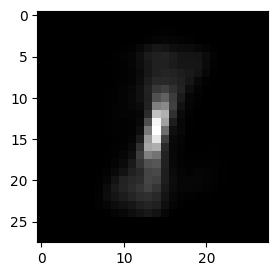

In [21]:
z = np.zeros(shape=(1, latent_dim)) # latent vector
label = np.array([[0,1,0,0,0,0,0,0,0,0]]) # label in one hot encoding
plt.figure(figsize=(3, 3))
plt.imshow(decoder.predict([z, label]).reshape(28,28), cmap = plt.cm.gray)
plt.show()

 # CVAE con capas convolucionales

## Data processing

In [22]:
(imgs_train, labels_train), (imgs_test, labels_test) = mnist.load_data()
imgs_train = (imgs_train.astype('float32') / 255)[:, :, :, np.newaxis]
imgs_test = (imgs_test.astype('float32') / 255)[:, :, :, np.newaxis]

labels_train = to_categorical(labels_train)
labels_test = to_categorical(labels_test)

In [23]:
print("image shape:", imgs_train.shape[1:])
print("n_cat shape:", labels_train.shape[1:])

image shape: (28, 28, 1)
n_cat shape: (10,)


## Modelamiento
### Hiperparámetros

In [24]:
batch_size = 250 # batch size
latent_dim = 2 # latent space size
optim = Adam(lr=0.001)
shape_img = imgs_train.shape[1:]
n_cat = labels_train.shape[1]
n_epoch = 50

### Encoder

In [27]:
enc_input_image = Input(shape=(shape_img), name="input_image")
enc_input_label = Input(shape=(n_cat), name="input_label")

# convolutionals block
conv1 = Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(enc_input_image)
conv2 = Conv2D(filters=64, kernel_size=3, strides=2, activation='relu')(conv1)

# concat
flattened = Flatten()(conv2)
enc_concat = Concatenate()([flattened, enc_input_label])

encoder_hidden = Dense(512, name="hidden_layer")(enc_concat)
mu = Dense(latent_dim, activation='linear', name="mu")(encoder_hidden)
l_sigma = Dense(latent_dim, activation='linear', name="l_sigma")(encoder_hidden)
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(latent_dim, ), mean=0., stddev=1.) # shape antes => (batch_size, latent_dim)
    return mu + K.exp(l_sigma / 2) * eps
z = Lambda(sample_z, output_shape = (latent_dim, ), name="latent_vector")([mu, l_sigma]) # output encoder

encoder = Model([enc_input_image, enc_input_label], z, name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 13, 13, 32)           320       ['input_image[0][0]']         
                                                                                                  
 conv2d_1 (Conv2D)           (None, 6, 6, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten_1 (Flatten)         (None, 2304)                 0         ['conv2d_1[0][0]']            
                                                                                            

### Decoder

In [28]:
dec_inp_latent_vector = Input(shape=(latent_dim), name="input_latent_vector")
decoder_inp_label = Input(shape=(n_cat), name = "input_label")
dec_concat = Concatenate(name="decoder_concat")([dec_inp_latent_vector, decoder_inp_label])

decoder_hidden = Dense(512, activation="relu", name="hidden_layer")(dec_concat)
decoder_hidden = Dense(7*7*32, activation="relu", name="hidden_layer2")(decoder_hidden)
reshaped = Reshape(target_shape=(7,7,32))(decoder_hidden)

# convolutionals block
dec_conv1 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation="relu", padding='same')(reshaped)
dec_conv2 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation="relu", padding='same')(dec_conv1)
dec_output_img = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')(dec_conv2)
dec_output_img = Flatten()(dec_output_img)
decoder = Model([dec_inp_latent_vector, decoder_inp_label], dec_output_img, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_latent_vector (Input  [(None, 2)]                  0         []                            
 Layer)                                                                                           
                                                                                                  
 input_label (InputLayer)    [(None, 10)]                 0         []                            
                                                                                                  
 decoder_concat (Concatenat  (None, 12)                   0         ['input_latent_vector[0][0]', 
 e)                                                                  'input_label[0][0]']         
                                                                                            

### Conditional Variational autoencoder

In [29]:
latent_vector = encoder(inputs=[enc_input_image, enc_input_label]) # z
output_img = decoder(inputs=[latent_vector, enc_input_label])
CVAE = Model(inputs=[enc_input_image, enc_input_label], outputs=output_img, name="CVAE")
CVAE.summary()

Model: "CVAE"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_label (InputLayer)    [(None, 10)]                 0         []                            
                                                                                                  
 encoder (Functional)        (None, 2)                    1206148   ['input_image[0][0]',         
                                                                     'input_label[0][0]']         
                                                                                                  
 decoder (Functional)        (None, 784)                  848289    ['encoder[0][0]',          

## Entrenamiento

In [30]:
def vae_loss(y_true, y_pred):
    recon = recon_loss(y_true, y_pred)
    kl = KL_loss(y_true, y_pred)
    return recon + kl

def KL_loss(y_true, y_pred): # it doesnt use y_true and y_pred but the parameters are necessary for compiling
     # importante se usan las capas de mu y sigma del encoder
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [31]:
CVAE.compile(optimizer=optim, loss=vae_loss, metrics=[KL_loss, recon_loss])

In [32]:
# the output of the decoder is a flattened img, 
# so we need to flatten the true values (input images from (28,28,1) => 784)
y_train = imgs_train.reshape(imgs_train.shape[0], -1)
y_test = imgs_test.reshape(imgs_test.shape[0], -1)
print(y_train.shape)

(60000, 784)


In [33]:
cvae_hist = CVAE.fit([imgs_train, labels_train], y_train, verbose = 1, batch_size=batch_size, epochs=n_epoch,
                      validation_data = ([imgs_test, labels_test], y_test),
                      callbacks = [EarlyStopping(patience = 5)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50


2023-07-24 14:38:03.908778: W tensorflow/c/c_api.cc:304] Operation '{name:'training_2/Adam/conv2d_transpose_5/kernel/v/Assign' id:2026 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/conv2d_transpose_5/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/conv2d_transpose_5/kernel/v, training_2/Adam/conv2d_transpose_5/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


60000/60000 [==============================] - ETA: 0s - loss: 211.5188 - KL_loss: 3.3711 - recon_loss: 208.1476

2023-07-24 14:38:20.227075: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_1/mul' id:1461 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/decoder_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


60000/60000 [==============================] - 17s 287us/sample - loss: 211.5188 - KL_loss: 3.3711 - recon_loss: 208.1476 - val_loss: 163.4804 - val_KL_loss: 3.7319 - val_recon_loss: 159.7484
Epoch 2/50
60000/60000 [==============================] - 17s 280us/sample - loss: 159.5977 - KL_loss: 3.3337 - recon_loss: 156.2641 - val_loss: 152.6196 - val_KL_loss: 3.4018 - val_recon_loss: 149.2178
Epoch 3/50
60000/60000 [==============================] - 17s 280us/sample - loss: 149.4043 - KL_loss: 3.5902 - recon_loss: 145.8141 - val_loss: 146.1235 - val_KL_loss: 3.1574 - val_recon_loss: 142.9661
Epoch 4/50
60000/60000 [==============================] - 17s 282us/sample - loss: 147.0586 - KL_loss: 3.8095 - recon_loss: 143.2491 - val_loss: 153.9128 - val_KL_loss: 3.3044 - val_recon_loss: 150.6085
Epoch 5/50
60000/60000 [==============================] - 17s 282us/sample - loss: 145.8171 - KL_loss: 4.0380 - recon_loss: 141.7791 - val_loss: 143.5939 - val_KL_loss: 4.1873 - val_recon_loss: 139.4

## Prediccion

2023-07-24 17:19:37.604714: W tensorflow/c/c_api.cc:304] Operation '{name:'flatten_2/Reshape' id:1225 op device:{requested: '', assigned: ''} def:{{{node flatten_2/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](conv2d_transpose_5/BiasAdd, flatten_2/Const)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


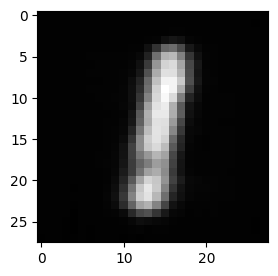

In [34]:
z = np.zeros(shape=(1, latent_dim))  # latent vector
label = np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])  # label in one hot encoding
plt.figure(figsize=(3, 3))
plt.imshow(decoder.predict([z, label]).reshape(28, 28), cmap=plt.cm.gray)
plt.show()